In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from matplotlib import gridspec as gridspec

import os
import warnings


In [2]:
def set_seed(seed = 31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [3]:
ds_train_ = image_dataset_from_directory('./archive (1)/train',
                                        labels = 'inferred',
                                        label_mode = 'binary',
                                        image_size = [128, 128],
                                        batch_size = 64,
                                        interpolation = 'nearest',
                                        shuffle = True,)
ds_valid_ = image_dataset_from_directory('./archive (1)/valid',  labels = 'inferred',
                                        label_mode = 'binary',
                                        image_size = [128, 128],
                                        batch_size = 64,
                                        interpolation = 'nearest',
                                        shuffle = True,)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [4]:
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

In [5]:
AUTOTUNE = tf.data.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters = 32,
                  kernel_size = 3,
                  activation = 'relu',
                  padding = 'same',
                  input_shape = (128, 128, 3)),
    layers.MaxPool2D(),
    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.Conv2D(filters=128, kernel_size = 3,activation='relu',padding='same'),
    layers.Conv2D(filters=128, kernel_size = 3,activation='relu',padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid'),
])

c:\Users\91972\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.compile(
    optimizer = keras.optimizers.Adam(epsilon=0.01),
    loss = 'binary_crossentropy',
    metrics = ['binary_accuracy']
)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    ds_train,
    validation_data = ds_valid,
    epochs = 30,
    verbose = 1,
    callbacks = [early_stop]
)

Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 75s 937ms/step - binary_accuracy: 0.5759 - loss: 0.6718 - val_binary_accuracy: 0.6030 - val_loss: 0.6576
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - binary_accuracy: 0.5972 - loss: 0.6593 - val_binary_accuracy: 0.6193 - val_loss: 0.6561
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 72s 889ms/step - binary_accuracy: 0.5960 - loss: 0.6577 - val_binary_accuracy: 0.6217 - val_loss: 0.6441
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 65s 819ms/step - binary_accuracy: 0.6055 - loss: 0.6486 - val_binary_accuracy: 0.6337 - val_loss: 0.6374
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 65s 818ms/step - binary_accuracy: 0.6275 - loss: 0.6422 - val_binary_accuracy: 0.6266 - val_loss: 0.6367
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 833ms/step - binary_accuracy: 0.6354 - loss: 0.6323 - val_binary_accuracy: 0.6541 - val_loss: 0.6138
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 67s 836ms/step - binary_accuracy: 0.6624 - loss: 0.6198 - val_binary_accuracy: 0.6822 - val_loss: 0.5983
Ep

<Axes: >

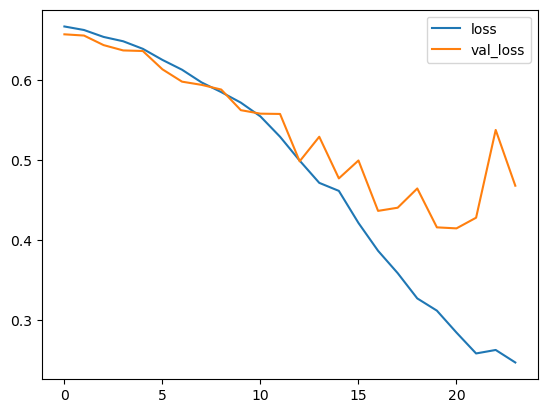

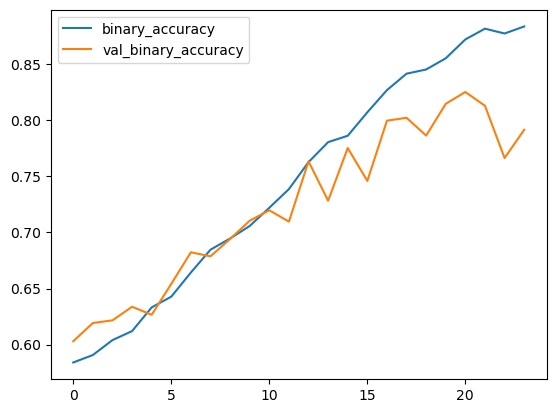

In [10]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

In [11]:
model.save("model.h5")
